In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

import os

from skimage.metrics import peak_signal_noise_ratio
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

# Loss 
mse = torch.nn.MSELoss()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)

print(f'Using device {device}')

Using device cuda


In [3]:
IMAGE = 'zebra'
factor = 4

checkpoint_file = f'checkpoints/sr_{IMAGE}_{factor}'

input_depth = 32
output_depth = 3

if IMAGE == 'zebra':
    fname = './data/sr/zebra_GT.png'
    
    nd = [128, 128, 128, 128, 128]
    nu = nd[:]
    kd = [3, 3, 3, 3, 3]
    ku = kd[:]
    ns = [4, 4, 4, 4, 4]
    ks = [1, 1, 1, 1, 1]
else:
    assert False

In [4]:
from models import *
from models.unet import *

from utils import *

downsampler = lanczos_downsampler(output_depth, factor, device=device)

net = UNet(input_depth, output_depth, nu, nd, ns, ku, kd, ks)
net.to(device)

print(f'Image is {IMAGE}')
print(net)

Image is zebra
UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv

In [5]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

Number of params: 2217831


Image dim : (3, 384, 576)


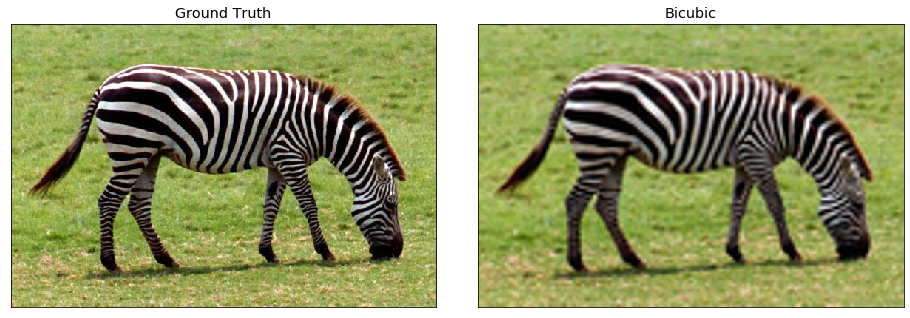

In [6]:
from input_gen import *

img_hr_pil = crop_image(get_image(fname, -1)[0])
img_hr_np = pil_to_np(img_hr_pil)
img_hr_tr = torch.from_numpy(img_hr_np).type(torch.FloatTensor)

hr_width, hr_height = img_hr_pil.size
lr_size = (hr_width // factor, hr_height // factor)
img_lr_pil = img_hr_pil.resize(lr_size, Image.LANCZOS)
img_lr_np = pil_to_np(img_lr_pil)
img_lr_tr = torch.from_numpy(img_lr_np).type(torch.FloatTensor)

img_bicubic_pil = img_lr_pil.resize(img_hr_pil.size, Image.BICUBIC)
img_bicubic_np = pil_to_np(img_bicubic_pil)
img_bicubic_tr = torch.from_numpy(img_bicubic_np).type(torch.FloatTensor)

print(f'Image dim : {img_hr_np.shape}')

fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr],
                              titles=['Ground Truth', 'Bicubic'],
                              figsize=(16,16))

In [7]:
target_img = img_hr_tr
target_img = target_img.unsqueeze(dim=0).to(device)
net_input = get_noise(input_depth, *img_hr_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()

# HyperParmaters for each image
if factor == 4:
    LR = 0.01
    num_iter = 2000
    reg_noise_std = 1.0/30
elif factor == 8:
    LR = 0.01
    num_iter = 4000
    reg_noise_std = 1.0/20
        
print(f'Hyperparameters : LR = {LR},  num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : LR = 0.01,  num_iter = 2000,  std = 0.03333333333333333


# Regular Training (no input optimization or adversarial training)

In [8]:
TRAIN_TYPE = 'regular'

checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'

training = True
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    net.load_state_dict(saved_state['model_state'])
    net_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:

    # Training loop, can change hyperparameters mid way
    show_every = 100
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    psnr_lr_res = []
    psnr_hr_res = []
    losses_res = []
    best_psnr = 0.0

    for i in range(num_iter):
        optimizer.zero_grad()

        if reg_noise_std > 0:
            net_input_mod = net_input + (noise.normal_() * reg_noise_std)
        else:
            net_input_mod = net_input.clone()

        out = net(net_input_mod)
        out_copy = out.detach().cpu()
        out_down = downsampler(out)

        loss = mse(out_down, img_lr_tr.to(device))
        loss.backward()

        optimizer.step()

        psnr_lr = peak_signal_noise_ratio(img_lr_np, out_down.detach().cpu().numpy()[0]) 
        psnr_hr = peak_signal_noise_ratio(img_hr_np, out_copy.numpy()[0])

        psnr_lr_res.append(psnr_lr)
        psnr_hr_res.append(psnr_hr)
        losses_res.append(loss.item())
        
        if psnr_hr > best_psnr:
            best_psnr = psnr_hr

        print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR = %06f' % 
              (i, loss.item(), psnr_lr, psnr_hr), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR=%06f' % 
                  (i, loss.item(), psnr_lr, psnr_hr))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_hr_tr, out_copy[0]], 
                                          titles=['Original', f'Iteration: {i}'])

    print(f'Done training final Loss = {loss.item()}   PSNR_LR = {psnr_lr}   PSNR_HR = {psnr_hr}')
    fig, axes = tensors_as_images([img_hr_tr, out_copy[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])
    
    saved_state = dict(best_psnr=best_psnr, model_state=net.state_dict(), net_input=net_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/sr_zebra_4_regular_final.pt instead of training
Best psnr of saved model : 23.81703321023239


In [9]:
def plot_experiment_results(results, exp_name, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('psnr_hr', 'psnr_lr', 'loss')):
        ax = fig.axes[i]
        if plot_type not in results:
            continue
        exp_res = results[plot_type]    
        ax.plot(list(range(len(exp_res))), exp_res, label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('iteration')
        ax.legend()
    return fig
    
experiments_results_fig = None
if training:
    experiments_results_fig = plot_experiment_results({'psnr_hr': psnr_hr_res, 'psnr_lr': psnr_lr_res, 'loss': losses_res}, 'Regular')

C:\Users\User\Miniconda3\envs\cs236781-hw\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


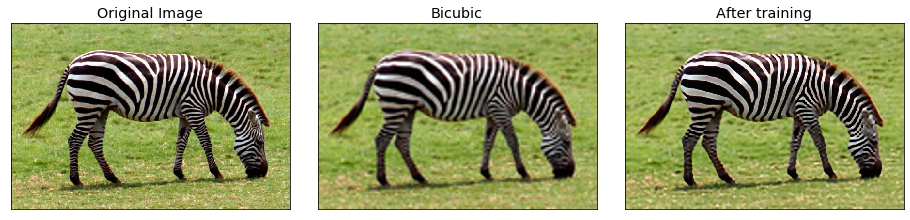

In [10]:
# Showing result of the training
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    
    fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr, output], 
                                        titles=['Original Image', 'Bicubic', 'After training'],
                                        figsize=(16,16))
    
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/sr/{IMAGE}_{factor}.png')
    
    normal_training_output = output

# Regular Training with input optimization

In [12]:
net = UNet(input_depth, output_depth, nu, nd, ns, ku, kd, ks)
net.to(device)

new_input = net_input.detach().clone()
noise = new_input.detach().clone()

Image dim : (3, 384, 576)


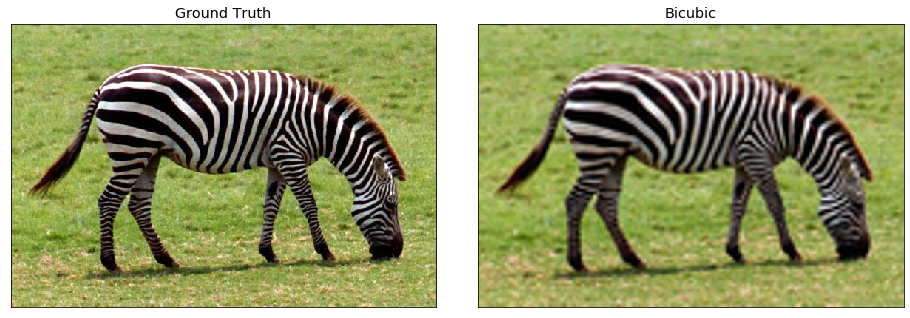

In [13]:
print(f'Image dim : {img_hr_np.shape}')

fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr],
                              titles=['Ground Truth', 'Bicubic'],
                              figsize=(16,16))

In [14]:
noise = net_input.detach().clone()

# HyperParmaters for each image
if factor == 4:
    inp_lr = 0.01
    net_lr = 0.01
    num_iter = 2000
    reg_noise_std = 1.0/30
elif factor == 8:
    inp_lr = 0.001
    net_lr = 0.001
    num_iter = 4000
    reg_noise_std = 0.001
        
print(f'Hyperparameters : INPUT_LR = {inp_lr}, NETWORK_LR = {net_lr}, num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : INPUT_LR = 0.01, NETWORK_LR = 0.01, num_iter = 2000,  std = 0.03333333333333333


In [15]:
inp_optimizer = torch.optim.Adam([new_input.requires_grad_()], lr=inp_lr)
net_optimizer = torch.optim.Adam(net.parameters(), lr=net_lr)

show_every = 100

psnr_lr_res = []
psnr_hr_res = []
losses_res = []

In [16]:
TRAIN_TYPE = 'input_optim'

checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'

training = True
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    net.load_state_dict(saved_state['model_state'])
    new_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    best_psnr = 0.0
    
    for i in range(num_iter):
        inp_optimizer.zero_grad()
        net_optimizer.zero_grad()

        if reg_noise_std > 0:
            net_input_mod = new_input + (noise.normal_() * reg_noise_std)
        else:
            net_input_mod = new_input.clone()

        out = net(net_input_mod)
        out_copy = out.detach().cpu()
        out_down = downsampler(out)

        loss = mse(out_down, img_lr_tr.to(device))
        loss.backward()

        inp_optimizer.step()
        net_optimizer.step()

        psnr_lr = peak_signal_noise_ratio(img_lr_np, out_down.detach().cpu().numpy()[0]) 
        psnr_hr = peak_signal_noise_ratio(img_hr_np, out_copy.numpy()[0])
        
        if psnr_hr > best_psnr:
            best_psnr = psnr_hr

        psnr_lr_res.append(psnr_lr)
        psnr_hr_res.append(psnr_hr)
        losses_res.append(loss.item())

        print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR = %06f' % 
              (i, loss.item(), psnr_lr, psnr_hr), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Loss = %06f   PSNR_LR = %06f   PSNR_HR=%06f' % 
                  (i, loss.item(), psnr_lr, psnr_hr))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_hr_tr, out_copy[0]], 
                                          titles=['Original', f'Iteration: {i}'])

    print(f'Done training final Loss = {loss.item()}   PSNR_LR = {psnr_lr}   PSNR_HR = {psnr_hr}')
    fig, axes = tensors_as_images([img_hr_tr, out_copy[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'])
    
    saved_state = dict(best_psnr=best_psnr, model_state=net.state_dict(), net_input=new_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/sr_zebra_4_input_optim_final.pt instead of training
Best psnr of saved model : 22.89378902979411


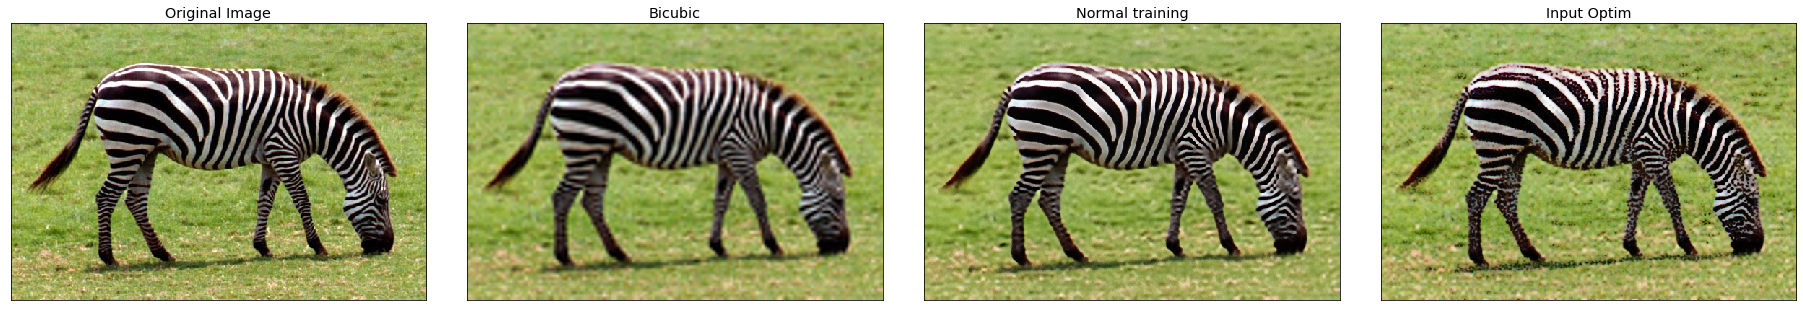

In [17]:
# Showing result of the training
with torch.no_grad():
    new_input = new_input.detach()
    output = net(new_input).detach()
    output = output.squeeze(dim=0)
    
    fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr, normal_training_output, output], 
                                    titles=['Original Image', 'Bicubic', 'Normal training', 'Input Optim'],
                                    figsize=(32,32))
    
    input_optim_output = output.clone().detach().cpu()
    output_pil = np_to_pil(input_optim_output.numpy())
    output_pil.save(f'results/sr/{IMAGE}_input_optimization_{factor}.png')
    

In [18]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr_hr': psnr_hr_res, 'psnr_lr': psnr_lr_res, 'loss': losses_res}, 'Input Optim', fig=experiments_results_fig)

# Adverserial training

In [19]:
from models.adverserialModel import *

# Models

if IMAGE == 'zebra':
    gen = UNet(input_depth, output_depth, nu, nd, ns, ku, kd, ks)
else:
    assert False    
gen.to(device)

dsc = Discriminator(img_lr_tr.shape).to(device)

In [20]:
# Hyperparams
show_every = 50

if factor == 4:
    reg_noise_std = 0.005
    DSC_LR = 0.001
    GEN_LR = 0.001
    WEIGHT_DECAY = 0.00
    DATA_LABEL = 1
    LABEL_NOISE = 0.0
    num_iter = 1800

    OPTIMIZE_INPUT = True
    INP_LR = 0.01
elif factor == 8:
    reg_noise_std = 0.00
    DSC_LR = 0.001
    GEN_LR = 0.001
    WEIGHT_DECAY = 0.00
    DATA_LABEL = 1
    LABEL_NOISE = 0.0
    num_iter = 4000

    OPTIMIZE_INPUT = False
    INP_LR = 0.01
else:
    assert False

In [21]:
# net input
adv_input = net_input.clone().detach()
if OPTIMIZE_INPUT:
    inp_optimizer = torch.optim.Adam([adv_input.requires_grad_()], INP_LR, weight_decay=WEIGHT_DECAY)

# Optimizers
dsc_optimizer = torch.optim.Adam(dsc.parameters(), DSC_LR, weight_decay=WEIGHT_DECAY)
gen_optimizer = torch.optim.Adam(gen.parameters(), GEN_LR, weight_decay=WEIGHT_DECAY)

# Losses
def dsc_loss_fn(y_data, y_generated):
    return discriminator_loss_fn(y_data, y_generated, DATA_LABEL, LABEL_NOISE)

def gen_loss_fn(y_generated):
    return generator_loss_fn(y_generated, DATA_LABEL)

# Discriminator input processing
def gen_fn(y, *not_used):
    return downsampler(y)

In [22]:
TRAIN_TYPE = 'adversarial'

checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'

target_img = img_lr_tr.clone().unsqueeze(dim=0).to(device)

training = True
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    gen.load_state_dict(saved_state['model_state'])
    adv_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    psnr_hr_res = []
    psnr_lr_res = []
    best_psnr = 0.0

    for i in range(num_iter):
        if OPTIMIZE_INPUT:
            inp_optimizer.zero_grad()

        if reg_noise_std > 0:
            adv_input_mod = adv_input + (noise.normal_() * reg_noise_std)
        else:
            adv_input_mod = adv_input.clone()

        dsc_loss, gen_loss, output = train_batch(dsc, gen, dsc_loss_fn, gen_loss_fn,
                                                dsc_optimizer, gen_optimizer,
                                                target_img, adv_input_mod,
                                                gen_fn=gen_fn)

        if OPTIMIZE_INPUT:
            inp_optimizer.step()

        psnr_lr = peak_signal_noise_ratio(img_lr_np, downsampler(output).detach().cpu().numpy()[0]) 
        psnr_hr = peak_signal_noise_ratio(img_hr_np, output.detach().clone().cpu().numpy()[0])
        
        if psnr_hr > best_psnr:
            best_psnr = psnr_hr

        psnr_lr_res.append(psnr_lr)
        psnr_hr_res.append(psnr_hr)

        print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR_LR = %06f   PSNR_HR = %06f' % 
              (i, gen_loss, dsc_loss, psnr_lr, psnr_hr), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR_LR = %06f   PSNR_HR = %06f' % 
                  (i, gen_loss, dsc_loss, psnr_lr, psnr_hr))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_hr_tr, output[0].detach()], 
                                          titles=['Original', f'Iteration: {i}'])
            
    saved_state = dict(best_psnr=best_psnr, model_state=gen.state_dict(), net_input=adv_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/sr_zebra_4_adversarial_final.pt instead of training
Best psnr of saved model : 22.22374455509479


In [23]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr_hr': psnr_hr_res, 'psnr_lr': psnr_lr_res}, 'Adverserial', fig=experiments_results_fig)

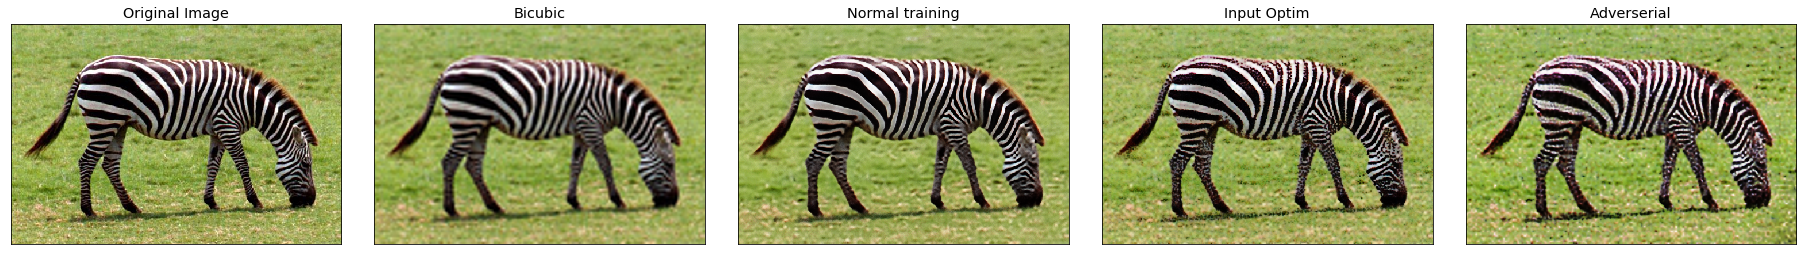

In [24]:
# Showing result of the training
with torch.no_grad():
    new_input = adv_input.detach()
    output = gen(adv_input).detach()
    output = output.squeeze(dim=0)
    
    adverserial_output = output.clone().detach().cpu()
    
    fig, axes = tensors_as_images([img_hr_tr, img_bicubic_tr, normal_training_output, input_optim_output, adverserial_output], 
                                    titles=['Original Image', 'Bicubic', 'Normal training', 'Input Optim', 'Adverserial'],
                                    figsize=(32,32))
    
    output_pil = np_to_pil(adverserial_output.numpy())
    output_pil.save(f'results/sr/{IMAGE}_adverserial_{factor}.png')